In [2]:
import os
#from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
#from keras.applications.resnet50 import preprocess_input, decode_predictions
#from keras.preprocessing.image import ImageDataGenerator, load_img
#from keras.applications.resnet50 import ResNet50
#from keras.preprocessing import image
#from keras.models import Sequential
#from keras.models import Model
#from keras.callbacks import ModelCheckpoint, EarlyStopping
#import matplotlib.pyplot as plt
#import numpy as np
import joblib


from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [13]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import numpy as np
from sklearn.decomposition import PCA

def preprocess(train_data_dir, valid_data_dir, test_data_dir):
    img_height, img_width = (227, 227)  # Image dimensions assumed for AlexNet
    batch_size = 32

    # Data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = train_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical')

    # Preprocess images using PCA
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    pca.fit(train_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Transform image data using PCA
    pca_train_data = pca.transform(train_generator[0][0].reshape(-1, img_height * img_width * 3))
    pca_valid_data = pca.transform(valid_generator[0][0].reshape(-1, img_height * img_width * 3))
    pca_test_data = pca.transform(test_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Create new generators with transformed data
    pca_train_generator = (pca_train_data, train_generator[0][1])
    pca_valid_generator = (pca_valid_data, valid_generator[0][1])
    pca_test_generator = (pca_test_data, test_generator[0][1])

    return pca, pca_train_generator, pca_test_generator, pca_valid_generator

def pca_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Flatten layer
    x = Flatten()(input_layer)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=predictions)

    return model

def model_trainer(epochs=10):
    train_data_dir = "/workspace/data/data_dir/model-data/train"
    test_data_dir = "/workspace/data/data_dir/model-data/test"
    valid_data_dir = "/workspace/data/data_dir/model-data/val"

    pca, pca_train_generator, pca_test_generator, pca_valid_generator = preprocess(
        train_data_dir=train_data_dir,
        test_data_dir=test_data_dir,
        valid_data_dir=valid_data_dir)

    num_classes = pca_train_generator[1].shape[1]  # Get number of classes from the generator
    input_shape = (pca_train_generator[0].shape[1],)  # Adjust input shape according to PCA components
    model = pca_model(input_shape, num_classes)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_callback = ModelCheckpoint('/workspace/data/data_dir/saved/best/best_model.h5',
                                          monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    log_dir = "/workspace/data/data_dir/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    model.fit(
        pca_train_generator[0],
        pca_train_generator[1],
        epochs=epochs,
        validation_data=(pca_valid_generator[0], pca_valid_generator[1]),
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
    )

    return model


if __name__ == '__main__':
    pca_model = model_trainer(epochs=10)
    pca_model.save('/workspace/data/data_dir/saved/saved_model.h5')



Found 1750 images belonging to 3 classes.
Found 249 images belonging to 3 classes.
Found 502 images belonging to 3 classes.
Epoch 1/10


2024-02-29 11:53:17.996614: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 11:53:18.465252: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2024-02-29 11:53:18.465426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2839 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:90:00.0, compute capability: 8.0


1/1 [==============================] - ETA: 0s - loss: 5.8016 - accuracy: 0.1875
Epoch 1: val_loss improved from inf to 1.10727, saving model to /workspace/data/data_dir/saved/best/best_model.h5


2024-02-29 11:53:19.899305: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 1s 1s/step - loss: 5.8016 - accuracy: 0.1875 - val_loss: 1.1073 - val_accuracy: 0.7812
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.9375
Epoch 2: val_loss did not improve from 1.10727
1/1 [==============================] - 0s 68ms/step - loss: 0.4726 - accuracy: 0.9375 - val_loss: 1.8356 - val_accuracy: 0.8438
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.9688
Epoch 3: val_loss did not improve from 1.10727
1/1 [==============================] - 0s 67ms/step - loss: 0.4469 - accuracy: 0.9688 - val_loss: 2.4299 - val_accuracy: 0.8438
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.9688
Epoch 4: val_loss did not improve from 1.10727
1/1 [==============================] - 0s 70ms/step - loss: 0.4530 - accuracy: 0.9688 - val_loss: 2.8421 - val_accuracy: 0.8438
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 0.3998 

Found 1750 images belonging to 3 classes.
Found 249 images belonging to 3 classes.
Found 502 images belonging to 3 classes.
Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 4.0436 - accuracy: 0.2188
Epoch 1: val_loss improved from inf to 0.74583, saving model to /workspace/data/data_dir/saved/best/best_model.h5
1/1 [==============================] - 1s 639ms/step - loss: 4.0436 - accuracy: 0.2188 - val_loss: 0.7458 - val_accuracy: 0.9062
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.9062
Epoch 2: val_loss did not improve from 0.74583
1/1 [==============================] - 0s 109ms/step - loss: 0.6704 - accuracy: 0.9062 - val_loss: 0.7642 - val_accuracy: 0.9062
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.9062
Epoch 3: val_loss improved from 0.74583 to 0.63914, saving model to /workspace/data/data_dir/saved/best/best_model.h5
1/1 [==============================] - 0s 160ms/step - loss: 0.

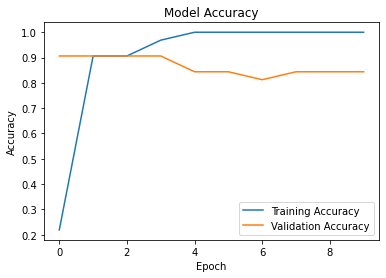

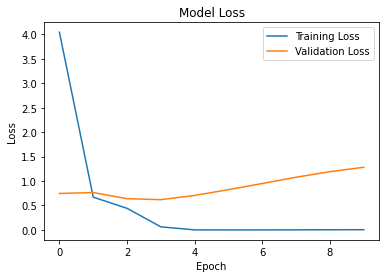

In [14]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def preprocess(train_data_dir, valid_data_dir, test_data_dir):
    img_height, img_width = (227, 227)  # Image dimensions assumed for AlexNet
    batch_size = 32

    # Data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = train_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical')

    # Preprocess images using PCA
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    pca.fit(train_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Transform image data using PCA
    pca_train_data = pca.transform(train_generator[0][0].reshape(-1, img_height * img_width * 3))
    pca_valid_data = pca.transform(valid_generator[0][0].reshape(-1, img_height * img_width * 3))
    pca_test_data = pca.transform(test_generator[0][0].reshape(-1, img_height * img_width * 3))

    # Create new generators with transformed data
    pca_train_generator = (pca_train_data, train_generator[0][1])
    pca_valid_generator = (pca_valid_data, valid_generator[0][1])
    pca_test_generator = (pca_test_data, test_generator[0][1])

    return pca, pca_train_generator, pca_test_generator, pca_valid_generator

def pca_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Flatten layer
    x = Flatten()(input_layer)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=predictions)

    return model

def model_trainer(epochs=10):
    train_data_dir = "/workspace/data/data_dir/model-data/train"
    test_data_dir = "/workspace/data/data_dir/model-data/test"
    valid_data_dir = "/workspace/data/data_dir/model-data/val"

    pca, pca_train_generator, pca_test_generator, pca_valid_generator = preprocess(
        train_data_dir=train_data_dir,
        test_data_dir=test_data_dir,
        valid_data_dir=valid_data_dir)

    num_classes = pca_train_generator[1].shape[1]  # Get number of classes from the generator
    input_shape = (pca_train_generator[0].shape[1],)  # Adjust input shape according to PCA components
    model = pca_model(input_shape, num_classes)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_callback = ModelCheckpoint('/workspace/data/data_dir/saved/best/best_model.h5',
                                          monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
    log_dir = "/workspace/data/data_dir/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    history = model.fit(
        pca_train_generator[0],
        pca_train_generator[1],
        epochs=epochs,
        validation_data=(pca_valid_generator[0], pca_valid_generator[1]),
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
    )

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


if __name__ == '__main__':
    pca_model = model_trainer(epochs=10)
    pca_model.save('/workspace/data/data_dir/saved/saved_model.h5')
